In [1]:
# Importando os módulos que serão utilizados

import tensorflow as tf
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import time

# Configurando o acesso do tensorflow aos processadores do computador
# no caso, está sendo selecionada a primeira placa de vídeo listada

gpus= tf.config.experimental.list_physical_devices('GPU') # Listando as placas de vídeo
tf.config.experimental.set_memory_growth(gpus[0], True)   # Selecionando a primeira GPU e configurando

# Importando os módulos contendo as funções criadas no projeto

from aux_func_V3 import *
import API_Numpy
import API_TensorFlow

float_pres = 'float64' # Definindo a precisão padrão para as análises

In [2]:
Sim_Z, Sim_step_Z, DerivadaEspacial_Z, Get_weights_Z=create_simulation(API_Numpy,transp_equation,WENO_Z)
Sim_JS, Sim_step_JS, DerivadaEspacial_JS, Get_weights_JS=create_simulation(API_Numpy,transp_equation,WENO_JS)

In [3]:
# Criando uma camada de Burgers que integra o WENO à rede neural
Δx = 0.01
CFL=0.5
Sim_layer = WENO_temporal(Δx, CFL, Δx*CFL, FronteiraFixa,transp_equation,WENO_Z,ativ_func=tf.nn.sigmoid)
Sim_net, Sim_step_net, DerivadaEspacial_net, Get_weights_net=tf.function(Sim_layer.Sim), tf.function(Sim_layer.Sim_step), tf.function(Sim_layer.DerivadaEspacial), tf.function(Sim_layer.Get_weights)

In [4]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([200], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando a rede neural
Network = keras.Model(input_x, Sim_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['MSE'])
# Carregando os pesos da rede neural treinados
#Network.load_weights('Modelo artigo')

In [5]:
# Carregando os pesos treinados
Network.load_weights('Modelos treinados/Modelo Rede temporal transp - 1.h5')

In [ ]:
Sim_cont, Sim_step_cont, DerivadaEspacial_cont, Get_weights_cont=create_simulation(API_Numpy,burgers_equation,Continuous_case)
Sim_Z, Sim_step_Z, DerivadaEspacial_Z, Get_weights_Z=create_simulation(API_Numpy,burgers_equation,WENO_Z)

# Visualizando os resultados

Δx_ref = 0.01                                  # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: np.exp(-10*x**2)

CFL = 0.5 # Constante utilizada para determinar o tamanho da malha temporal
T   = 1     # Instante de tempo final

erros=[]
WENOs=[Sim_cont,Sim_Z]
malha=[1,1]
axs=[]
lines=[]
U=[]
names=['Esquema não ponderado', 'Esquema WENO']
r=len(names)

fig = plt.figure(1, constrained_layout=True, figsize=(8*3,6))
ax1=fig.add_subplot(1, 3, 1)
ax2=fig.add_subplot(1, 3, 2)
ax3=fig.add_subplot(1, 3, 3)
for i,j,name,ax in zip(range(r),malha,names,[ax1,ax2]):
    Δx=Δx_ref/j
    x  = np.arange(-1, 1, Δx, dtype=float_pres)

    U_i = f_test(x)
    U_i = np.expand_dims(U_i ,axis=0)
    U.append(U_i)
    ax.grid(ls='--')
    #ax.xaxis.set_ticks(x)

    ax.set_ylim(-0.1,1.1)
    ax.title.set_text(name)
    lines.append(ax.plot(x, tf.squeeze(U_i)))

min_x=100-2
max_x=100+8

ω_Z,α_Z,β_Z,δ_Z=Get_weights_Z(U[1],FronteiraPeriodica)

# Inserindo os pontos nos gráficos
left=ax3.plot(x[min_x:max_x], ω_Z[0,min_x:max_x,0], 's', color='red'  , alpha=1,label='Esquerda')
center=ax3.plot(x[min_x:max_x], ω_Z[0,min_x:max_x,1], 'D', color='black', alpha=1,label='Central')
right=ax3.plot(x[min_x:max_x], ω_Z[0,min_x:max_x,2], 'o', color='blue' , alpha=1,label='Direita')
ax3.legend()

# Criando as linhas horizontais dos gráficos
ax3.hlines(
    y          = 1/10,
    xmin       = min(x),
    xmax       = max(x),
    color      = 'red',
    linestyles = '--'
)
ax3.hlines(
    y          = 6/10,
    xmin       = min(x),
    xmax       = max(x),
    color      = 'black',
    linestyles = '--'
)
ax3.hlines(
    y          = 3/10,
    xmin       = min(x),
    xmax       = max(x),
    color      = 'blue',
    linestyles = '--'
)
y_line1=ax1.vlines(
    x          = x[100],
    ymin       = -0.1,
    ymax       = 1.1,
    color      = 'black',
    linestyles = '--'
)
y_line2=ax2.vlines(
    x          = x[100],
    ymin       = -0.1,
    ymax       = 1.1,
    color      = 'black',
    linestyles = '--'
)
y_line3=ax3.vlines(
    x          = x[100],
    ymin       = 1.1,
    ymax       = 10**-8,
    color      = 'black',
    linestyles = '--'
)

ax3.set_yscale('log')
ax3.set_xlim(x[min_x-1],x[max_x])
ax3.set_ylim(10**-8,10**0*1.1)
ax3.xaxis.set_ticks(x)
ax3.yaxis.set_ticks(10**np.arange(-8, 0, 1.0))
ax3.grid(ls='--')

hfig = display(fig, display_id=True)

t=np.float64(0.0)
Δt=np.float64(0.01)
count=0

while t < T:
    for i,line,Sim,k in zip(range(r),lines,WENOs,malha):
        U[i] = Sim(U[i],
                np.float64(Δt),
                np.float64(Δx_ref/k),
                np.float64(CFL),
                FronteiraPeriodica
                    )
        squeezed_u=np.squeeze(U[i])
            
        # Exibindo graficamente os valores obtidos
        line[0].set_ydata(squeezed_u) 

    center_x=np.argmax(U[1])
    min_x=center_x-2
    max_x=center_x+8
    y_line1.set_segments([np.asarray(
                        [[x[center_x],-0.1],
                         [x[center_x],1.1]])])
    y_line2.set_segments([np.asarray(
                        [[x[center_x],-0.1],
                         [x[center_x],1.1]])])
    y_line3.set_segments([np.asarray(
                        [[x[center_x],10**-8],
                         [x[center_x],1.1]])])
    
    left[0].set_xdata(  x[min_x:max_x])
    center[0].set_xdata(x[min_x:max_x])
    right[0].set_xdata( x[min_x:max_x])    

    
    ax3.set_xlim(x[min_x-1],x[max_x])

    ω_Z,α_Z,β_Z,δ_Z=Get_weights_Z(U[1],FronteiraPeriodica)

    # Inserindo os pontos nos gráficos
    left[0].set_ydata(  ω_Z[0,min_x:max_x,0])
    center[0].set_ydata(ω_Z[0,min_x:max_x,1])
    right[0].set_ydata( ω_Z[0,min_x:max_x,2])

    t += Δt
    count+=1
    fig.canvas.draw()
    hfig.update(fig)
    print('t: ',np.squeeze(t),'                                ',end='\r')
    plt.savefig('imagens/Comparacao WENO/Comparacao WENO {}.png'.format(str(count).zfill(4)))

In [ ]:
Sim_Z, Sim_step_Z, DerivadaEspacial_Z, Get_weights_Z=create_simulation(API_Numpy,burgers_equation,WENO_Z)

Sim_layer = WENO_temporal(Δx, CFL, Δx*CFL, FronteiraFixa,burgers_equation,WENO_Z,ativ_func=tf.nn.sigmoid)
Sim_net, Sim_step_net, DerivadaEspacial_net, Get_weights_net=tf.function(Sim_layer.Sim), tf.function(Sim_layer.Sim_step), tf.function(Sim_layer.DerivadaEspacial), tf.function(Sim_layer.Get_weights)
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([200], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando a rede neural
Network = keras.Model(input_x, Sim_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['MSE'])
# Carregando os pesos da rede neural treinados
#Network.load_weights('Modelo artigo')
# Carregando os pesos treinados
Network.load_weights('Modelos treinados/Modelo Rede temporal transp - 1.h5')

# Visualizando os resultados

Δx_ref = 0.01                                  # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: np.exp(-10*x**2)

CFL = 0.5 # Constante utilizada para determinar o tamanho da malha temporal
T   = 1     # Instante de tempo final

erros=[]
WENOs=[Sim_Z,Sim_net]
malha=[1,1]
axs=[]
lines=[]
U=[]
names=['WENO-Z', 'WENO-DS']
r=len(names)

fig = plt.figure(1, constrained_layout=True, figsize=(8*3,6))
ax1=fig.add_subplot(1, 3, 1)
ax2=fig.add_subplot(1, 3, 2)
ax3=fig.add_subplot(1, 3, 3)
for i,j,name,ax in zip(range(r),malha,names,[ax1,ax2]):
    Δx=Δx_ref/j
    x  = np.arange(-1, 1, Δx, dtype=float_pres)

    U_i = f_test(x)
    U_i = np.expand_dims(U_i ,axis=0)
    U.append(U_i)
    ax.grid(ls='--')
    #ax.xaxis.set_ticks(x)

    ax.set_ylim(-0.1,1.1)
    ax.title.set_text(name)
    lines.append(ax.plot(x, tf.squeeze(U_i)))

min_x=100-2
max_x=100+8

ω_DS,α_DS,β_DS,δ_DS=Get_weights_net(U[1],FronteiraPeriodica)

# Inserindo os pontos nos gráficos
left=ax3.plot(x[min_x:max_x], δ_DS[0,min_x:max_x,0], 's', color='red'  , alpha=1,label='Esquerda')
center=ax3.plot(x[min_x:max_x], δ_DS[0,min_x:max_x,1], 'D', color='black', alpha=1,label='Central')
right=ax3.plot(x[min_x:max_x], δ_DS[0,min_x:max_x,2], 'o', color='blue' , alpha=1,label='Direita')
ax3.legend()

y_line1=ax1.vlines(
    x          = x[100],
    ymin       = -0.1,
    ymax       = 1.1,
    color      = 'black',
    linestyles = '--'
)
y_line2=ax2.vlines(
    x          = x[100],
    ymin       = -0.1,
    ymax       = 1.1,
    color      = 'black',
    linestyles = '--'
)
y_line3=ax3.vlines(
    x          = x[100],
    ymin       = -0.1,
    ymax       = 1.1,
    color      = 'black',
    linestyles = '--'
)

#ax3.set_yscale('log')
ax3.set_xlim(x[min_x-1],x[max_x])
ax3.set_ylim(-0.1,1.1)
ax3.xaxis.set_ticks(x)
ax3.yaxis.set_ticks(np.arange(-0.1, 1.1, 0.1))
ax3.grid(ls='--')

hfig = display(fig, display_id=True)

t=np.float64(0.0)
Δt=np.float64(0.01)
count=0

while t < T:
    for i,line,Sim,k in zip(range(r),lines,WENOs,malha):
        U[i] = Sim(U[i],
                np.float64(Δt),
                np.float64(Δx_ref/k),
                np.float64(CFL),
                FronteiraPeriodica
                    )
        squeezed_u=np.squeeze(U[i])
            
        # Exibindo graficamente os valores obtidos
        line[0].set_ydata(squeezed_u) 

    center_x=np.argmax(U[1])
    min_x=center_x-2
    max_x=center_x+8
    y_line1.set_segments([np.asarray(
                        [[x[center_x],-0.1],
                         [x[center_x],1.1]])])
    y_line2.set_segments([np.asarray(
                        [[x[center_x],-0.1],
                         [x[center_x],1.1]])])
    y_line3.set_segments([np.asarray(
                        [[x[center_x],-0.1],
                         [x[center_x],1.1]])])
    
    left[0].set_xdata(  x[min_x:max_x])
    center[0].set_xdata(x[min_x:max_x])
    right[0].set_xdata( x[min_x:max_x])    

    
    ax3.set_xlim(x[min_x-1],x[max_x])

    ω_DS,α_DS,β_DS,δ_DS=Get_weights_net(U[1],FronteiraPeriodica)

    # Inserindo os pontos nos gráficos
    left[0].set_ydata(  δ_DS[0,min_x:max_x,0])
    center[0].set_ydata(δ_DS[0,min_x:max_x,1])
    right[0].set_ydata( δ_DS[0,min_x:max_x,2])

    t += Δt
    count+=1
    fig.canvas.draw()
    hfig.update(fig)
    print('t: ',np.squeeze(t),'                                ',end='\r')
    #plt.savefig('imagens/Comparacao WENO/Comparacao WENO DS {}.png'.format(str(count).zfill(4)))

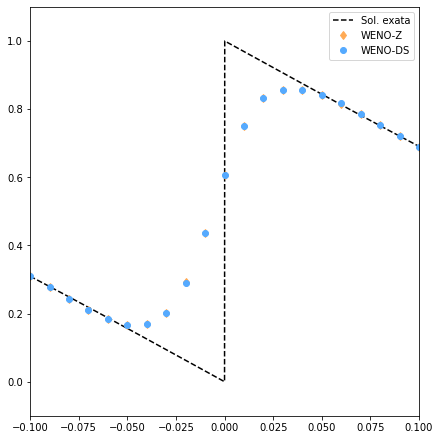

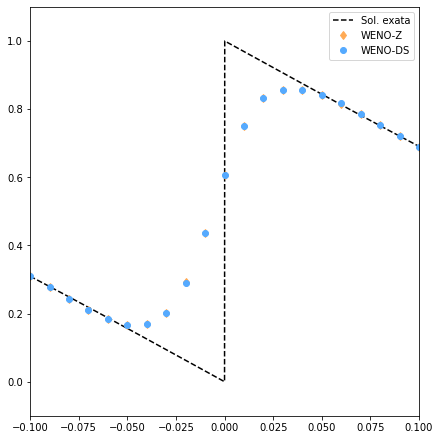

In [7]:
# Visualizando os resultados

Δx_ref = 0.01                                  # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: (-np.sin(np.pi*x) - 0.5 * x**3 + \
    np.where(x < 0, 0.0, 1.0))

f_exata= lambda u, t_final, Δx, CFL, fronteira: fronteira(u,API_Numpy,100)[...,:-200] 

CFL = 0.5 # Constante utilizada para determinar o tamanho da malha temporal
T   = 2     # Instante de tempo final

erros=[]
WENOs=[f_exata,Sim_Z,Sim_net]
malha=[100,1,1]
colors=['black','#ffaa55', '#55aaff']
shapes=['--','d','o']
ax=[]
lines=[]
U=[]
names=['Sol. exata','WENO-Z','WENO-DS']
r=len(names)

fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax=fig.add_subplot(1, 1, 1)
ax.set_xlim(-0.1, 0.1)
ax.set_ylim(-2, 2)
for i,j,name,color,shape in zip(range(r),malha,names,colors,shapes):
    Δx=Δx_ref/j
    x  = np.arange(-1, 1, Δx, dtype=float_pres)

    U_i = f_test(x)
    U_i = np.expand_dims(U_i ,axis=0)
    U.append(U_i)

    ax.set_ylim(-0.1,1.1)
    lines.append(ax.plot(x, tf.squeeze(U_i),shape,label=name,color=color))
ax.legend()
hfig = display(fig, display_id=True)

t=np.float64(0.0)
Δt=np.float64(0.01)
count=0

while t < T:
    for i,line,Sim,k in zip(range(r),lines,WENOs,malha):
        U[i] = Sim(U[i],
                np.float64(Δt),
                np.float64(Δx_ref/k),
                np.float64(CFL),
                FronteiraPeriodica
                    )
        squeezed_u=np.squeeze(U[i])
            
        # Exibindo graficamente os valores obtidos
        line[0].set_ydata(squeezed_u)  
    t += Δt
    count+=1
    fig.canvas.draw()
    hfig.update(fig)
    print('t: ',np.squeeze(t),'                                ',end='\r')
    plt.savefig('imagens/tranps ds transp zoomed/transp-ds zoomed {}.png'.format(count))

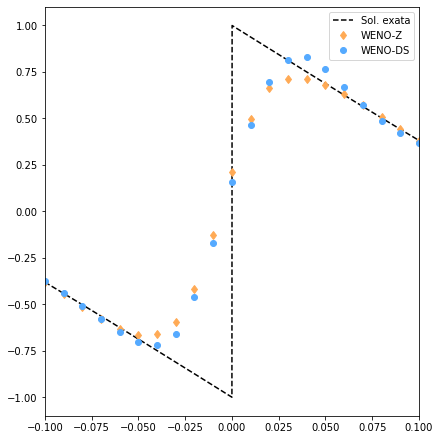

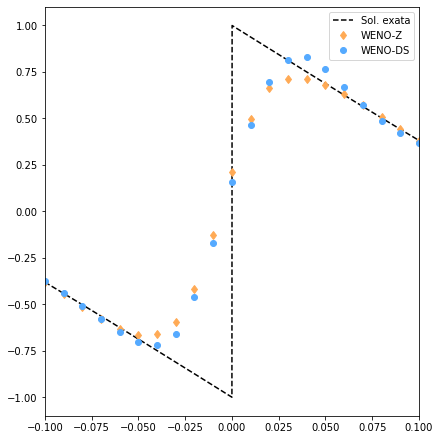

In [41]:
# Visualizando os resultados

Δx_ref = 0.01                                  # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: -1+2*(-np.sin(np.pi*x) - 0.5 * x**3 + \
    np.where(x < 0, 0.0, 1.0))

f_exata= lambda u, t_final, Δx, CFL, fronteira: fronteira(u,API_Numpy,100)[...,:-200] 

CFL = 0.5 # Constante utilizada para determinar o tamanho da malha temporal
T   = 2     # Instante de tempo final

erros=[]
WENOs=[f_exata,Sim_Z,Sim_net]
malha=[100,1,1]
colors=['black','#ffaa55', '#55aaff']
shapes=['--','d','o']
ax=[]
lines=[]
U=[]
names=['Sol. exata','WENO-Z','WENO-DS']
r=len(names)

fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax=fig.add_subplot(1, 1, 1)
ax.set_xlim(-0.1, 0.1)
for i,j,name,color,shape in zip(range(r),malha,names,colors,shapes):
    Δx=Δx_ref/j
    x  = np.arange(-1, 1, Δx, dtype=float_pres)

    U_i = f_test(x)
    U_i = np.expand_dims(U_i ,axis=0)
    U.append(U_i)

    ax.set_ylim(-1.1,1.1)
    lines.append(ax.plot(x, tf.squeeze(U_i),shape,label=name,color=color))
ax.legend()
hfig = display(fig, display_id=True)

t=np.float64(0.0)
Δt=np.float64(0.01)
count=0

while t < T:
    for i,line,Sim,k in zip(range(r),lines,WENOs,malha):
        U[i] = Sim(U[i],
                np.float64(Δt),
                np.float64(Δx_ref/k),
                np.float64(CFL),
                FronteiraPeriodica
                    )
        squeezed_u=np.squeeze(U[i])
            
        # Exibindo graficamente os valores obtidos
        line[0].set_ydata(squeezed_u)  
    t += Δt
    count+=1
    fig.canvas.draw()
    hfig.update(fig)
    print('t: ',np.squeeze(t),'                                ',end='\r')
    #plt.savefig('imagens/tranps ds zoomed/transp-ds zoomed {}.png'.format(count))

In [15]:
Sim_Z, Sim_step_Z, DerivadaEspacial_Z, Get_weights_Z=create_simulation(API_Numpy,burgers_equation,WENO_Z)
Sim_JS, Sim_step_JS, DerivadaEspacial_JS, Get_weights_JS=create_simulation(API_Numpy,burgers_equation,WENO_JS)

In [16]:
# Criando uma camada de Burgers que integra o WENO à rede neural
Δx = 0.01
CFL=0.5
Sim_layer = WENO_temporal(Δx, CFL, Δx*CFL, FronteiraFixa,burgers_equation,WENO_Z,ativ_func=tf.nn.sigmoid)
Sim_net, Sim_step_net, DerivadaEspacial_net, Get_weights_net=tf.function(Sim_layer.Sim), tf.function(Sim_layer.Sim_step), tf.function(Sim_layer.DerivadaEspacial), tf.function(Sim_layer.Get_weights)

In [17]:
# Definindo o input da rede e o otimizador de treino
input_x   = keras.layers.Input([200], dtype='float64')
optimizer = keras.optimizers.Adam(learning_rate=10**-3, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# Criando a rede neural
Network = keras.Model(input_x, Sim_layer(input_x))
# Configurando a função de perda e o otimizador
Network.compile(loss='mean_absolute_error', optimizer=optimizer, metrics=['MSE'])
# Carregando os pesos da rede neural treinados
#Network.load_weights('Modelo artigo')

In [18]:
# Carregando os pesos treinados
Network.load_weights('Modelos treinados/Modelo Rede temporal - 5.h5')

In [19]:
# Visualizando os resultados

Δx_ref = 0.01                                  # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
# f_test = lambda x: (-np.sin(np.pi*x) - 0.5 * x**3 + \
#     np.where(x < 0, 0.0, 1.0))

f_test = lambda x: np.exp(-10*x**2)

CFL = 0.5 # Constante utilizada para determinar o tamanho da malha temporal
T   = 1     # Instante de tempo final

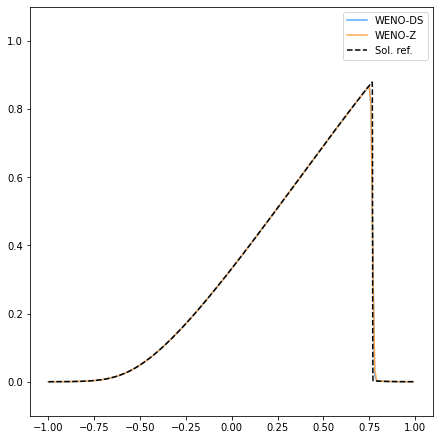

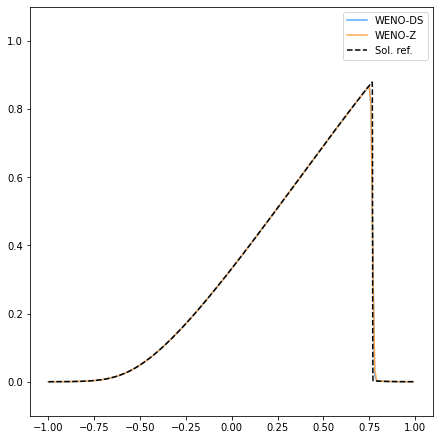

In [20]:
# Visualizando os resultados

Δx_ref = 0.01                                  # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
# f_test = lambda x: (-np.sin(np.pi*x) - 0.5 * x**3 + \
#     np.where(x < 0, 0.0, 1.0))

f_test = lambda x: np.exp(-10*x**2)

CFL = 0.5 # Constante utilizada para determinar o tamanho da malha temporal
T   = 1     # Instante de tempo final

erros=[]
WENOs=[Sim_net,Sim_Z,Sim_Z]
malha=[1,1,10]
ax=[]
lines=[]
U=[]
names=['WENO-DS','WENO-Z','Sol. ref.']
r=len(names)

fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax=fig.add_subplot(1, 1, 1)
ax.set_ylim(-2, 2)
for i,j,name,linetype,color in zip(range(r),malha,names,['-','-','--'],['#55aaff','#ffaa55','black']):
    Δx=Δx_ref/j
    x  = np.arange(-1, 1, Δx, dtype=float_pres)

    U_i = f_test(x)
    U_i = np.expand_dims(U_i ,axis=0)
    U.append(U_i)

    ax.set_ylim(-0.1,1.1)
    lines.append(ax.plot(x, tf.squeeze(U_i),linetype,label=name,color=color))
ax.legend()
hfig = display(fig, display_id=True)

t=0.0
Δt=0.01
count=0

while t < T:
    for i,line,Sim,k in zip(range(r),lines,WENOs,malha):
        U[i] = Sim(U[i],
                Δt,
                Δx_ref/k,
                CFL,
                FronteiraPeriodica
                    )
        squeezed_u=np.squeeze(U[i])
            
        # Exibindo graficamente os valores obtidos
        line[0].set_ydata(squeezed_u)  
    t += Δt
    count+=1
    fig.canvas.draw()
    hfig.update(fig)
    plt.savefig('imagens/burgers-ds 1/burgers-ds 1 {}.png'.format(str(count).zfill(4)))
    print('t: ',np.squeeze(t),'                                ',end='\r')

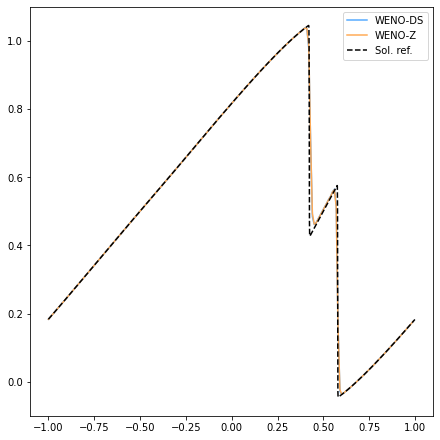

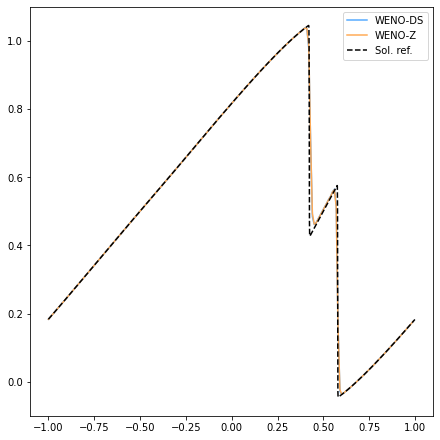

In [36]:
# Visualizando os resultados

Δx_ref = 0.01                                  # Distância espacial dos pontos na malha utilizada

# Condição inicial do artigo do WENO-Z
#-------------------------------------------------------------------------------------------
# Função definida no artigo
f_test = lambda x: (-np.sin(np.pi*x) - 0.5 * x**3 + \
    np.where(x < 0, 0.0, 1.0))

CFL = 0.5 # Constante utilizada para determinar o tamanho da malha temporal
T   = 1     # Instante de tempo final

erros=[]
WENOs=[Sim_net,Sim_Z,Sim_Z]
malha=[1,1,10]
ax=[]
lines=[]
U=[]
names=['WENO-DS','WENO-Z','Sol. ref.']
r=len(names)

fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax=fig.add_subplot(1, 1, 1)
ax.set_ylim(-2, 2)

for i,j,name,linetype,color in zip(range(r),malha,names,['-','-','--'],['#55aaff','#ffaa55','black']):
    Δx=Δx_ref/j
    x  = np.arange(-1, 1, Δx, dtype=float_pres)

    U_i = f_test(x)
    U_i = np.expand_dims(U_i ,axis=0)
    U.append(U_i)

    ax.set_ylim(-0.1,1.1)
    lines.append(ax.plot(x, tf.squeeze(U_i),linetype,label=name,color=color))
ax.legend()
hfig = display(fig, display_id=True)

t=0.0
Δt=0.01
count=0

while t < T:
    for i,line,Sim,k in zip(range(r),lines,WENOs,malha):
        U[i] = Sim(U[i],
                Δt,
                Δx_ref/k,
                CFL,
                FronteiraPeriodica
                    )
        squeezed_u=np.squeeze(U[i])
            
        # Exibindo graficamente os valores obtidos
        line[0].set_ydata(squeezed_u)  
    t += Δt
    count+=1
    fig.canvas.draw()
    hfig.update(fig)
    plt.savefig('imagens/burgers-ds 2 {}.png'.format(str(count).zfill(4)))
    print('t: ',np.squeeze(t),'                                ',end='\r')

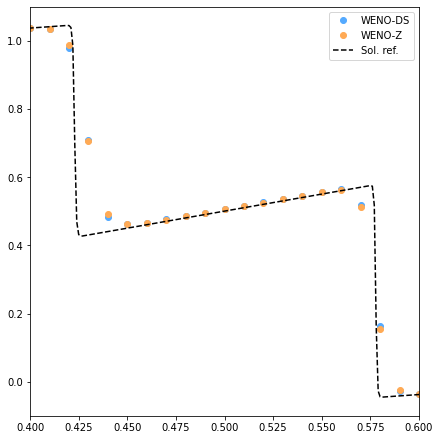

In [43]:
fig = plt.figure(1, constrained_layout=True, figsize=(6,6))
ax=fig.add_subplot(1, 1, 1)
ax.set_xlim(0.4, 0.6)
ax.set_ylim(-0.1,1.1)

for i,j,name,linetype,color in zip(range(r),malha,names,['o','o','--'],['#55aaff','#ffaa55','black']):
    Δx=Δx_ref/j
    x  = np.arange(-1, 1, Δx, dtype=float_pres)

    U_i = U[i]

    lines.append(ax.plot(x, tf.squeeze(U_i),linetype,label=name,color=color))
ax.legend()
plt.savefig('imagens/burgers 2 zoomed')

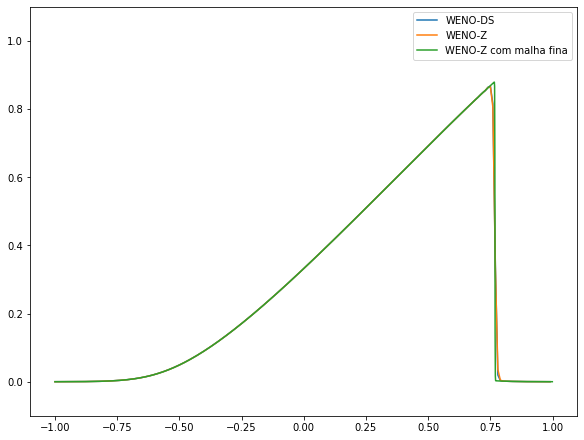

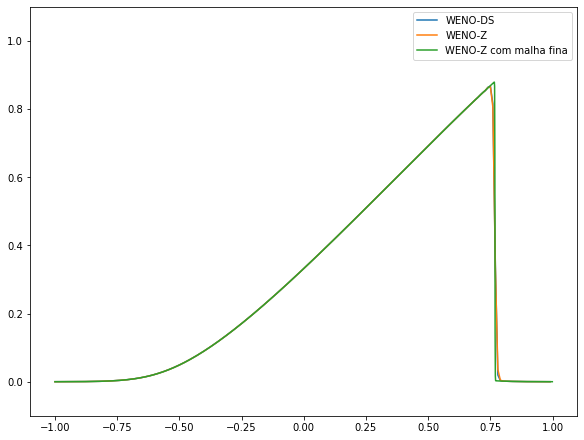

In [18]:
erros=[]
WENOs=[Sim_net,Sim_Z,Sim_Z]
malha=[1,1,10]
ax=[]
lines=[]
U=[]
names=['WENO-DS','WENO-Z','WENO-Z com malha fina']

fig = plt.figure(1, constrained_layout=True, figsize=(8,6))
ax=fig.add_subplot(1, 1, 1)
ax.set_ylim(-0.1, 1.1)
for i,j,name in zip(range(3),malha,names):
    Δx=Δx_ref/j
    x  = np.arange(-1, 1, Δx, dtype=float_pres)

    U_i = f_test(x)
    U_i = np.expand_dims(U_i ,axis=0)
    U.append(U_i)

    # ax.set_xlim(0,1)
    lines.append(ax.plot(x, tf.squeeze(U_i),label=name))
ax.legend()
hfig = display(fig, display_id=True)

t=0.0
Δt=0.05
count=0

while t < T:
    for i,line,Sim,k in zip(range(3),lines,WENOs,malha):
        U[i] = Sim(U[i],
                Δt,
                Δx_ref/k,
                CFL,
                FronteiraPeriodica
                    )
        squeezed_u=np.squeeze(U[i])
            
        # Exibindo graficamente os valores obtidos
        line[0].set_ydata(squeezed_u)  
    t += Δt
    count += 1
    fig.canvas.draw()
    hfig.update(fig)
    plt.savefig('imagens/Burgers evolve/evolve {}.png'.format(count))
    print('t: ',np.squeeze(t),'                                ',end='\r')

In [19]:
ref_full = tf.squeeze(tf.gather(U[2],(np.arange(U[0].shape[1])*malha[-1]).astype('int32'),axis=1))
net_u    = tf.squeeze(U[0])
debug_u  = tf.squeeze(U[1])

# Armazenando ambos os erros de previsão
error = tf.stack([net_u-ref_full,debug_u-ref_full],axis=0)[:,10:-10]

In [40]:
net_u.shape

TensorShape([200])

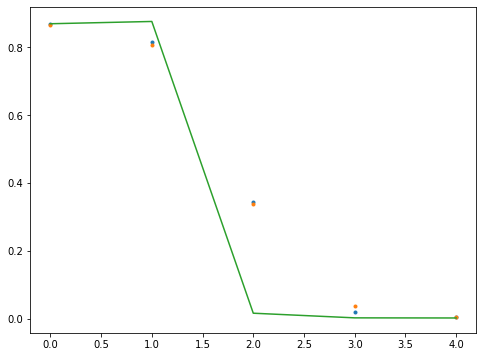

In [20]:
plt.figure(figsize=(8,6))
plt.plot(net_u[175:180],'.')
plt.plot(debug_u[175:180],'.')
plt.plot(ref_full[175:180])

In [21]:
# Calculando média dos erros de acordo com a norma L2, L1 ou L-inf

# Norma L2:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_mean(error**2, axis=1)**0.5
#--------------------------------------------------------------------------------------
print('L2:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Norma L1:
#--------------------------------------------------------------------------------------
desv_error = tf.math.reduce_mean(tf.abs(error), axis=1)
#--------------------------------------------------------------------------------------
print('L1:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())
print('\n')

# Noma L-inf:
#-------------------------------------------------------------------------------------
desv_error = tf.math.reduce_max(tf.abs(error), axis=1)
#--------------------------------------------------------------------------------------
print('L-inf:')
# Erro médio para a rede neural e o WENO-Z (respectivamente)
print(desv_error.numpy())
# Diferença entre os erros (WENO-Z - rede neural)
# print((desv_error[1]-desv_error[0]).numpy())
# Razão entre os erros (rede neural/WENO-Z)
print((desv_error[0]/desv_error[1]).numpy())

L2:
[0.02486822 0.02462791]
1.009757484710313


L1:
[0.00229276 0.00240154]
0.954702567435085


L-inf:
[0.32776012 0.32119895]
1.0204270981657413


In [8]:
# Visualizando os resultados

Δx = 0.01                                  # Distância espacial dos pontos na malha utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres) # Gerando a malha de pontos no espaço unidimensional

# Condição inicial do artigo do WENO-Z
# Função definida no artigo
f_test = lambda x: -tf.math.sin(np.pi*x) - 0.5 * x**3 + \
    tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(1.0, dtype=float_pres))

# f_test = lambda x: tf.math.exp(-10*(x**2)) + \
#     tf.where(x < 0, tf.constant(0.0, dtype=float_pres), tf.constant(-1.0, dtype=float_pres))

u = f_test(x)                 # Obtendo a condição inicial a partir de f_test
u = tf.expand_dims(u, axis=0) # Acrescentando uma dimensão

In [9]:
# Código que utiliza a fução pega_ponto para salvar os pesos gerados 
# por cada uma das versões do WENO de interesse

n_pontos  = 9   # Número de substêncis coletados
mid_point = 100 # Índice do ponto 'central'

y_plot_Rede = np.zeros([n_pontos,3]) # Array para salvar os valores dos pesos do WENO-Z com rede neural
y_plot_Z    = np.zeros([n_pontos,3]) # Array para salvar os valores dos pesos do WENO-Z
y_plot_JS    = np.zeros([n_pontos,3]) # Array para salvar os valores dos pesos do WENO-JS

#u0=slicer(FronteiraFixa(u,API_Numpy),5,API_Numpy)[0,1:-1]
ω_net,α_net,β_net,δ_net = Get_weights_net(u,FronteiraPeriodica)
#ω_net = np.expand_dims(ω_net[:,3],axis=0)
ω_Z,α_Z,β_Z,δ_Z    = Get_weights_Z(u,FronteiraPeriodica)
ω_JS,α_JS,β_JS,δ_JS    = Get_weights_JS(u,FronteiraPeriodica)

for i in range(n_pontos):
    
    indice = int(mid_point-(n_pontos-1)/2+i) # Determinadno o índice para a função
    
    y_plot_JS[i] = np.squeeze(ω_JS)[indice] # Armazenando os pesos do WENO-Z com rede neural
    y_plot_Z[i]    = np.squeeze(ω_Z)[indice] # Armazenando os pesos do WENO-Z
    y_plot_Rede[i] = np.squeeze(ω_net)[indice] # Armazenando os pesos do WENO-Z com rede neural

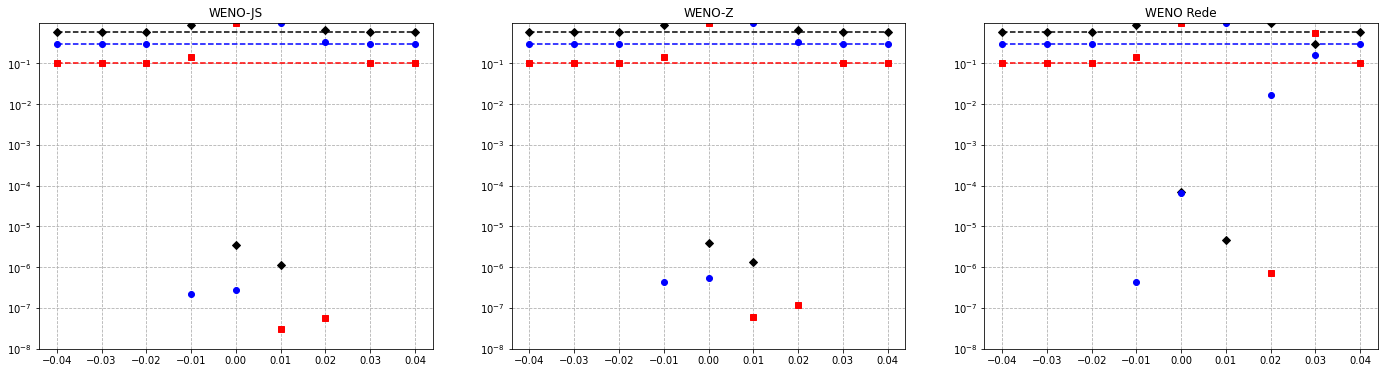

In [10]:
# Código que gera os gráficos comparando os pesos do WENO-Z e os pesos do WENO-Z
# modificados pela rede neural

# Criando os objetos que irão conter os plots
fig, axs = plt.subplots(1,3,figsize=(8*3, 6))

# Variáveis auxiliares para ajustar os limites dos gráficos
ylim  = (10**-8,(10**-0))
min_x = int(mid_point-(n_pontos-1)/2)
max_x = int(mid_point+(n_pontos+1)/2)

for i,y_plot,name in zip(range(3),[y_plot_JS,y_plot_Z,y_plot_Rede],['WENO-JS','WENO-Z','WENO Rede']):

    # Inserindo os pontos nos gráficos
    axs[i].plot(x[min_x:max_x], y_plot[:,0], 's', color='red'  , alpha=1)
    axs[i].plot(x[min_x:max_x], y_plot[:,1], 'D', color='black', alpha=1)
    axs[i].plot(x[min_x:max_x], y_plot[:,2], 'o', color='blue' , alpha=1)

    # Criando as linhas horizontais dos gráficos
    axs[i].hlines(
        y          = 1/10,
        xmin       = min(x[min_x:max_x]),
        xmax       = max(x[min_x:max_x]),
        color      = 'red',
        linestyles = '--'
    )
    axs[i].hlines(
        y          = 6/10,
        xmin       = min(x[min_x:max_x]),
        xmax       = max(x[min_x:max_x]),
        color      = 'black',
        linestyles = '--'
    )
    axs[i].hlines(
        y          = 3/10,
        xmin       = min(x[min_x:max_x]),
        xmax       = max(x[min_x:max_x]),
        color      = 'blue',
        linestyles = '--'
    )

    # Configuração de parâmetros gráficos referentes ao eixo y
    axs[i].set_yscale('log')
    axs[i].set_ylim(*ylim)
    axs[i].yaxis.set_ticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
    axs[i].grid(ls='--')
    axs[i].title.set_text(name)

# Exibindo os gráficos
#plt.show()
plt.savefig('imagens/omegas')

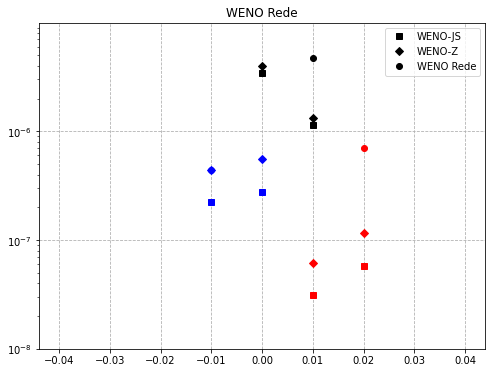

In [11]:
# Código que gera os gráficos comparando os pesos do WENO-Z e os pesos do WENO-Z
# modificados pela rede neural

# Criando os objetos que irão conter os plots
fig, axs = plt.subplots(1,1,figsize=(8, 6))

# Variáveis auxiliares para ajustar os limites dos gráficos
ylim  = (10**-8,(10**-5))
min_x = int(mid_point-(n_pontos-1)/2)
max_x = int(mid_point+(n_pontos+1)/2)

simbol=['s','D','o']

for i,y_plot,name,s in zip(range(3),[y_plot_JS,y_plot_Z,y_plot_Rede],['WENO-JS','WENO-Z','WENO Rede'],simbol):

    # Inserindo os pontos nos gráficos
    axs.plot(x[min_x:max_x], y_plot[:,0], s, color='red'  , alpha=1)
    axs.plot(x[min_x:max_x], y_plot[:,1], s, color='black', alpha=1,label=name)
    axs.plot(x[min_x:max_x], y_plot[:,2], s, color='blue' , alpha=1)

    # Criando as linhas horizontais dos gráficos
    axs.hlines(
        y          = 1/10,
        xmin       = min(x[min_x:max_x]),
        xmax       = max(x[min_x:max_x]),
        color      = 'red',
        linestyles = '--'
    )
    axs.hlines(
        y          = 6/10,
        xmin       = min(x[min_x:max_x]),
        xmax       = max(x[min_x:max_x]),
        color      = 'black',
        linestyles = '--'
    )
    axs.hlines(
        y          = 3/10,
        xmin       = min(x[min_x:max_x]),
        xmax       = max(x[min_x:max_x]),
        color      = 'blue',
        linestyles = '--'
    )

    # Configuração de parâmetros gráficos referentes ao eixo y
    axs.set_yscale('log')
    axs.set_ylim(*ylim)
    axs.yaxis.set_ticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
    axs.grid(ls='--')
    axs.legend()
    axs.title.set_text(name)

# Exibindo os gráficos
#plt.show()
plt.savefig('imagens/omegas juntos')

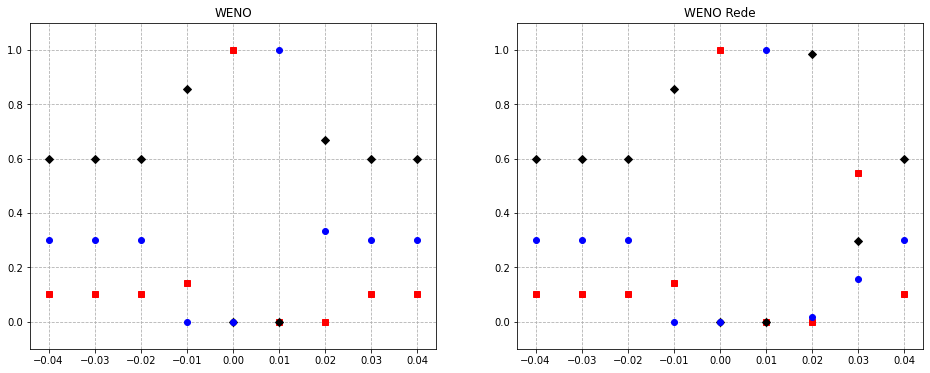

In [12]:
# Código que gera os gráficos comparando os pesos do WENO-Z e os pesos do WENO-Z
# modificados pela rede neural

# Criando os objetos que irão conter os plots
fig, axs = plt.subplots(1,2,figsize=(8*2, 6))

# Variáveis auxiliares para ajustar os limites dos gráficos
ylim  = (-0.1,1.1)
min_x = int(mid_point-(n_pontos-1)/2)
max_x = int(mid_point+(n_pontos+1)/2)

for i,y_plot,name in zip(range(2),[y_plot_Z,y_plot_Rede],['WENO','WENO Rede']):

    # Inserindo os pontos nos gráficos
    axs[i].plot(x[min_x:max_x], y_plot[:,0], 's', color='red'  , alpha=1)
    axs[i].plot(x[min_x:max_x], y_plot[:,1], 'D', color='black', alpha=1)
    axs[i].plot(x[min_x:max_x], y_plot[:,2], 'o', color='blue' , alpha=1)

    # # Criando as linhas horizontais dos gráficos
    # axs[i].hlines(
    #     y          = 1/10,
    #     xmin       = min(x[min_x:max_x]),
    #     xmax       = max(x[min_x:max_x]),
    #     color      = 'red',
    #     linestyles = '--'
    # )
    # axs[i].hlines(
    #     y          = 6/10,
    #     xmin       = min(x[min_x:max_x]),
    #     xmax       = max(x[min_x:max_x]),
    #     color      = 'black',
    #     linestyles = '--'
    # )
    # axs[i].hlines(
    #     y          = 3/10,
    #     xmin       = min(x[min_x:max_x]),
    #     xmax       = max(x[min_x:max_x]),
    #     color      = 'blue',
    #     linestyles = '--'
    # )

    # Configuração de parâmetros gráficos referentes ao eixo y
#    axs[i].set_yscale('log')
    axs[i].set_ylim(*ylim)
#    axs[i].yaxis.set_ticks(10**np.arange(np.log10(ylim[0]), np.log10(ylim[1]), 1.0))
    axs[i].grid(ls='--')
    axs[i].title.set_text(name)

# Exibindo os gráficos
#plt.show()
plt.savefig('imagens/betas')

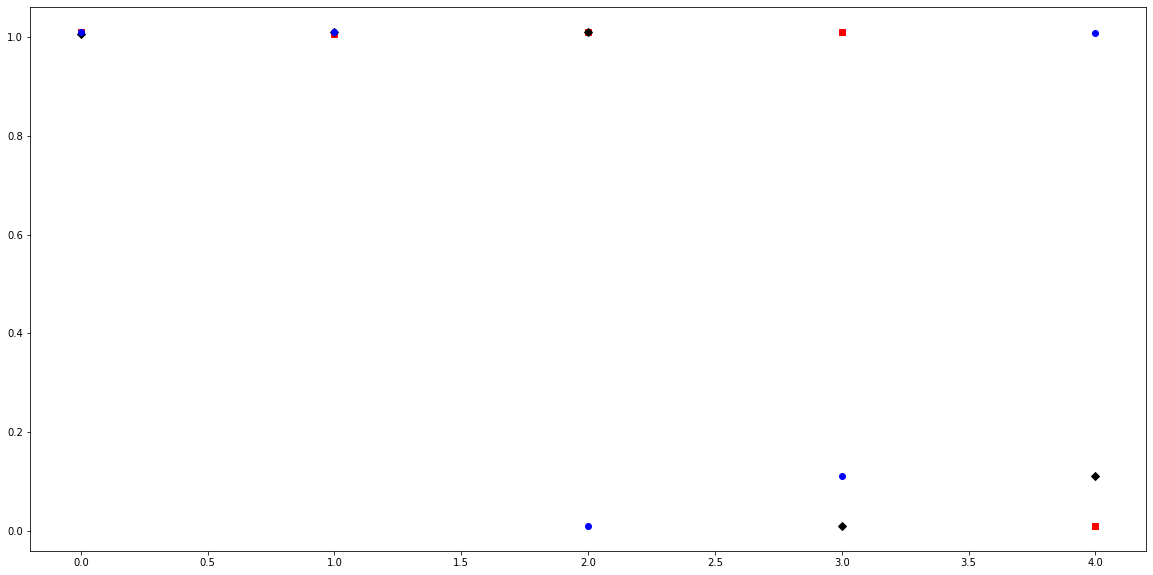

In [13]:
fig, axs = plt.subplots(1,1,figsize=(20, 10))
#ref=ω_net/ω_Z
ref=(β_net*(δ_net+0.01))/β_JS
plt.plot(np.squeeze(ref)[98:103,0],'s',color='red')
plt.plot(np.squeeze(ref)[98:103,1],'D',color='black')
plt.plot(np.squeeze(ref)[98:103,2],'o',color='blue')

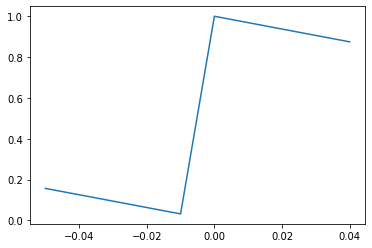

In [14]:
plt.plot(x[95:105],np.squeeze(u)[95:105])

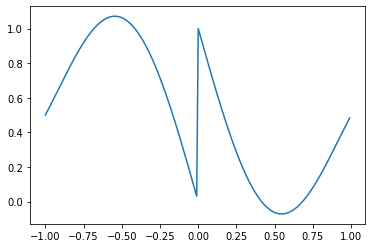

In [15]:
plt.plot(x,np.squeeze(u))

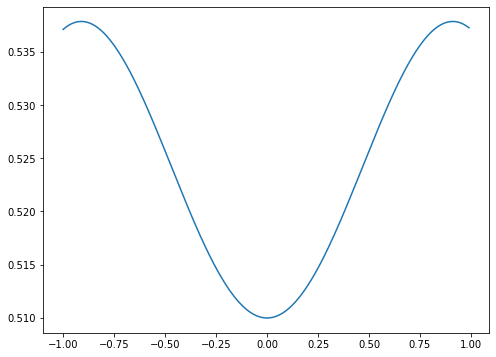

In [16]:
fig, axs = plt.subplots(1,1,figsize=(8, 6))
#plt.ylim(0,1)
Δx = 0.01                                  # Distância espacial dos pontos na malha utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres)
df_test = lambda x: -np.pi*tf.math.cos(np.pi*x) - 1.5 * x**2
#df_test = lambda x: -20*x*np.exp(-10*(x**2))
y=f_test(x)
y=FronteiraPeriodica(y,API_Numpy,1)
#dy=(y[2:]-y[:-2])/Δx
dy=(-df_test(x)+np.mean(df_test(x)))/11+0.6

s=lambda x: 1/(1+np.exp(-x))

plt.plot(x,s(-dy/4+0.25))
#plt.plot(x,4*np.squeeze(des_f(δ_net))[1:-1,1], 'o', color='black',label='Central')
#plt.plot(x,np.squeeze(δ_net)[1:-1,2], 'o', color='black',label='Central')

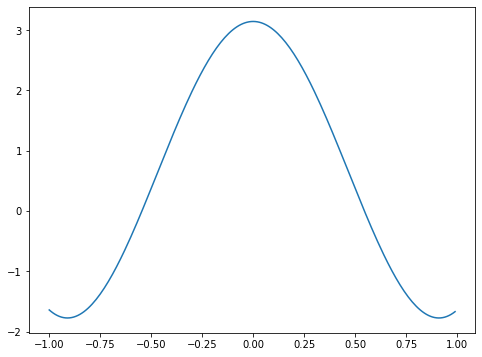

In [31]:
fig, axs = plt.subplots(1,1,figsize=(8, 6))
Δx = 0.01                                  # Distância espacial dos pontos na malha utilizada
x  = tf.range(-1, 1, Δx, dtype=float_pres)
df_test = lambda x: -np.pi*tf.math.cos(np.pi*x) - 1.5 * x**2
#df_test = lambda x: -20*x*np.exp(-10*(x**2))
plt.plot(x,-df_test(x))

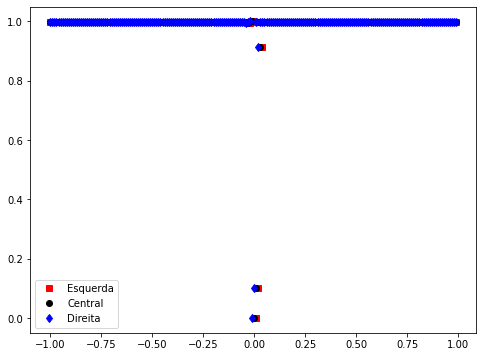

In [18]:
fig, axs = plt.subplots(1,1,figsize=(8, 6))

des_f=lambda y: y#-np.log(1/y-1)
#plt.xlim(-0.1,0.1)
#plt.plot(x,np.squeeze(des_f(δ_net))[1:-1,0], 's', color='red',label='Esquerda')
plt.plot(x,np.squeeze(des_f(δ_net))[1:-1,1], 'o', color='black',label='Central')
#plt.plot(x,np.squeeze(des_f(δ_net))[1:-1,2], 'd', color='blue',label='Direita')
plt.legend()
#plt.savefig('imagens/modificadores geral.png')

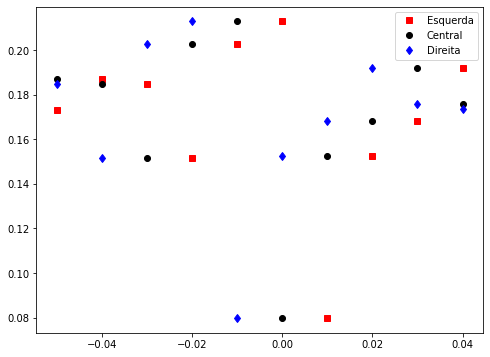

In [15]:
fig, axs = plt.subplots(1,1,figsize=(8, 6))
plt.plot(x[95:105],np.squeeze(δ_net)[1:-1,0][95:105], 's', color='red',label='Esquerda')
plt.plot(x[95:105],np.squeeze(δ_net)[1:-1,1][95:105], 'o', color='black',label='Central')
plt.plot(x[95:105],np.squeeze(δ_net)[1:-1,2][95:105], 'd', color='blue',label='Direita')
plt.legend()
plt.savefig('imagens/modificadores centro.png')

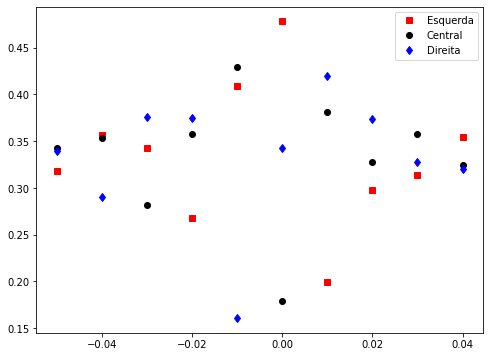

In [16]:
fig, axs = plt.subplots(1,1,figsize=(8, 6))

ref=np.squeeze(δ_net)[1:-1,:]
ref=ref/np.sum(ref,axis=-1,keepdims=True)

plt.plot(x[95:105],ref[:,0][95:105], 's', color='red',label='Esquerda')
plt.plot(x[95:105],ref[:,1][95:105], 'o', color='black',label='Central')
plt.plot(x[95:105],ref[:,2][95:105], 'd', color='blue',label='Direita')
plt.legend()
plt.savefig('imagens/modificadores centro 2.png')

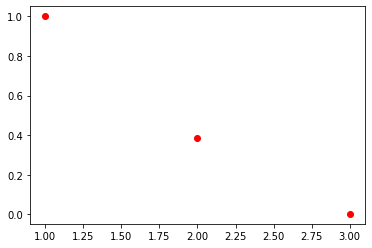

In [45]:
def net_call(x):
    y=x+0
    for layer in Sim_layer.layers:
        y = layer(y)
    return y

d1f=[1,2,-2,1,3]
d2f=[1,4,3,2,1]

inpt=np.stack([d1f,d2f],axis=1)
inpt=np.expand_dims(inpt,axis=0)
inpt=np.expand_dims(inpt,axis=0)
inpt=inpt.astype('float64')

call=net_call(np.asarray(inpt))[0,0,1:-1,0]
plt.plot([1,2,3],call,'ro')